- ## Preferred notebook for model creation with 100 trials; also used for label prediction (Feb, 2024)
- #### Morgan / Taylor's labeled sentences added in this version

#### This notebook tests for duplicates in labelled data

- This file creates model with MORE labelled data (Coded Sentences Drawn from Civic Center's Research and Taylor (1892_labeled_sentences.csv). Renamed "Label" column to "jim_crow".
- Added 11 updated files with correct splitting and coded by Axton : 1868_24-25_updated, 1868_143-145_updated, 1868_146-151_updated, 1877_571-586_updated.csv, 1884_24-26_updated.csv, 1886-87_1031-1034_updated.csv, 1886-87_1072-1074_updated.csv,1868_24-25_updated, 1896_63act_updated, 1907_518-522_updated, 1925_324act_updated, shared_base_training_set_v2.csv (from UNC)
- Converted the excel files coded by Axton to csv
- Renamed the above files to make the naming consistent (- replaced by _, added 'labeled_sentences')
- Renamed the column 'Coding (Axton)" of Civic Center data to 'jim_crow' , 'Act' to 'sentence' and 'Year' to 'year' for consistency
- Added column state = 'South Carolina' in all Civic Center coded files
- Replaced the 'year' values in file 1886_87_1031-1034.csv from '1886-87' to 1886 and '1868_146-151_updated.csv' from '1868-69' to 1868
- Changed case in some column names (upper to lower)
- Read "UNC_shared_base_training_set_v2.csv" file differently to perform some filteration as mentioned by Matthew Jansen (UNC) 
- CASE 1: Training and testing model on combined data of UNC and USC
- CASE 2: Training model on UNC data and testing model on USC data

- **Used SMOTEN to rebalance the imbalanced dataset and removed stopwords but the model performance did not improve in comparison to without SMOTEN/stopword removal.**
- **The time taken to create the model is very less than the time taken without SMOTEN/stopwords removal.**
- **This code DOES NOT predicts labels for the WHOLE CORPUS and for EACH YEAR**

## Case 1: Training and testing model on both USC and UNC data

### Import neccessary libraries

In [2]:
# data reading libraries
import numpy as np
import pandas as pd
from pathlib import Path

#Saving model so that we don't have to run it every time we open this notebook
import pickle 

# Text Libraries
import re
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords') 

# Machine Learning Libraries
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTEN
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

#Model Tuning Libraries
from hyperopt import hp, tpe, space_eval, Trials
from hyperopt.fmin import fmin

#Evaluation Libraries
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Supression
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vandana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read the data and store in dataframe

In [3]:
# Read data from the folder "LabeledData". Since one file "UNC_shared_base_training_set_v2.csv" is different from others, we are 
# reading it separately from others.
new_df = pd.DataFrame()

for file in Path("LabeledData_UNC_USC_Feb2024").glob('*.csv'):
    if str(file).find("base") != -1 :
        df1 = pd.read_csv(file)       # reading the "UNC_shared_base_training_set_v2.csv" file and store it in dataframe df1
    else: 
        df = pd.read_csv(file, usecols=['year', 'state','sentence', 'jim_crow'])
        new_df = new_df.append(df, ignore_index = True)

In [4]:
# Read first 5 rows of "UNC_shared_base_training_set_v2.csv" file whose columns are different from other csv files
df1[['jim_crow']] = df1[['jim_crow']].astype(int) # Change the datatype of jim_crow" to int in df1 (it is 0.0, 1.0, 2.0 currently)
df1.head()

,corpus_section_id,source,law_type,UNC_training,state,sentence,section_sents,char_len,reviewer,jim_crow,jim_crow_type,year,corpus_sentence_id
0,1947_session laws_979_2,murray,session laws,1.0,NORTH CAROLINA,Subject only to restrictions and conditions no...,1.0,779.0,NaN,1,explicit,1947,NaN
1,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,Powers and duties of Commission.,10.0,32.0,Axton,0,explicit,1935,NaN
2,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,10.0,146.0,Axton,0,explicit,1935,NaN
3,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",10.0,53.0,Axton,0,explicit,1935,NaN
4,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"and instructional supplies, which are, or may ...",10.0,218.0,Axton,0,explicit,1935,NaN


In [5]:
# find length of df1
len(df1)

10231

#### Only select rows which have a 'jim_crow' value of either 0 or 1
df.loc[df.jim_crow.isin([0,1]), :]

#### Only select rows which have a 'jim_crow_type' value of 'extrinsic' or 'implicit'
df.loc[df.jim_crow_type.isin(["extrinsic","implicit"]), :]

#### Only select rows which DONT have a 'jim_crow_type' value of 'extrinsic' or 'implicit' by using '~'
df.loc[~df.jim_crow_type.isin(["extrinsic","implicit"]), :]

In [6]:
# Only select those rows which have value of either 0 or 1 in "jim_crow" column AND do not have value of "extrinsic" or 
# "intrinsic" in "jim_crow_type" column ---- as suggested by Matt Jansen (UNC)
df1_good = df1.loc[(df1.jim_crow.isin([0,1])) & (~df1.jim_crow_type.isin(["extrinsic","implicit"])),:].copy()
df1_good.head()

,corpus_section_id,source,law_type,UNC_training,state,sentence,section_sents,char_len,reviewer,jim_crow,jim_crow_type,year,corpus_sentence_id
0,1947_session laws_979_2,murray,session laws,1.0,NORTH CAROLINA,Subject only to restrictions and conditions no...,1.0,779.0,NaN,1,explicit,1947,NaN
1,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,Powers and duties of Commission.,10.0,32.0,Axton,0,explicit,1935,NaN
2,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,10.0,146.0,Axton,0,explicit,1935,NaN
3,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",10.0,53.0,Axton,0,explicit,1935,NaN
4,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"and instructional supplies, which are, or may ...",10.0,218.0,Axton,0,explicit,1935,NaN


In [7]:
# Create a new dataframe from df1_good that has columns same as new_df
new_df1 = df1_good[['year', 'state', 'sentence', 'jim_crow']]
new_df1

,year,state,sentence,jim_crow
0,1947,NORTH CAROLINA,Subject only to restrictions and conditions no...,1
1,1935,NORTH CAROLINA,Powers and duties of Commission.,0
2,1935,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,0
3,1935,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",0
4,1935,NORTH CAROLINA,"and instructional supplies, which are, or may ...",0
...,...,...,...,...
10225,1909,NORTH CAROLINA,On behalf of the general welfare of the city o...,0
10226,1895,NORTH CAROLINA,"The clerk of the commissioners, on or before t...",1
10228,1899,NORTH CAROLINA,The township school trustees shall divide thei...,0
10229,1899,NORTH CAROLINA,They shall consult the convenience and necessi...,1


### Data Cleaning and Exploration

In [8]:
# display first 5 rows of the data new_df
new_df.head()

,year,state,sentence,jim_crow
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0.0
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0.0
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0.0
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0.0
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0.0


In [9]:
#replace '1886-87' in "year" column by 1886 and '1868-69' by 1868
new_df.replace('1886-87', '1886', inplace=True)
new_df.replace('1868-69', '1868', inplace=True)
new_df[new_df['year'] == '1868-69'].head() # emplty dataframe because we have replaced "1886-87" by "1886"

,year,state,sentence,jim_crow


In [10]:
# find the size of each dataframe
print(" The length of new_df is", len(new_df))
print(" The length of new_df1 is", len(new_df1))

 The length of new_df is 27072
 The length of new_df1 is 9492


In [11]:
# Check how many entries are null or empty in the two datasets
print(new_df.isnull().sum().sum())
print(new_df1.isnull().sum().sum())

13086
0


##### Remove all the null entries - coming from the 3 files shared by Morgan/Taylor

In [12]:
new_df_clean = new_df.dropna(subset=['jim_crow'])
print(new_df_clean.isnull().sum().sum())

0


In [13]:
# find the data types of columns of new_df1 and new_df
print("Column datatypes of new_df_clean are below: \n", new_df_clean.dtypes)
print("Column datatypes of new_df1 are below: \n", new_df1.dtypes)

Column datatypes of new_df_clean are below: 
 year         object
state        object
sentence     object
jim_crow    float64
dtype: object
Column datatypes of new_df1 are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object


Make sure that the data type of the two dataframes are SAME as we are going to append the datasets to create ONE large dataset

In [14]:
# Change the datatype of "year" and "jim_crow" to string in new_df1 
#new_df1[['jim_crow']] = new_df1[['jim_crow']].astype(int)
#new_df1[['year']] = new_df1[['year']].astype(str)

# # Change the datatype of 'year' to string in new_df
new_df_clean[['year']] = new_df_clean[['year']].astype(int)
new_df_clean[['jim_crow']] = new_df_clean[['jim_crow']].astype(int)

In [15]:
# find the data types of columns of new_df1 and new_df after changing
print("Column datatypes of new_df_clean are below: \n", new_df_clean.dtypes)
print("Column datatypes of new_df1 are below: \n", new_df1.dtypes)

Column datatypes of new_df_clean are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object
Column datatypes of new_df1 are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object


In [16]:
new_df.year.unique()


array([1896, 1907, '1886', 1937, 1922, 1877, 1879, 1898, 1900, 1903, 1904,
       1905, 1908, 1909, 1910, 1911, 1912, 1914, 1915, 1916, 1917, 1918,
       1920, 1924, 1926, 1928, 1930, 1934, 1872, 1878, 1906, 1891, 1923,
       1935, 1938, 1939, 1940, 1943, 1944, 1945, 1947, 1933, 1927, 1925,
       1913, 1899, 1901, 1941, 1949, 1889, 1887, 1885, 1883, 1881, 1880,
       1897, 1893, 1895, 1929, 1931, 1919, 1955, 1959, 1967, 1965, 1957,
       1869, 1963, 1951, 1868, 1961, 1870, 1921, 1953, 1876, 1871, 1866,
       1874, 1873, 1956, 1888, 1952, 1892, 1884, '1868'], dtype=object)

#### Append the 2 datasets to create a big labeled dataset

In [17]:
# Create a large dataset with the 2 separate datasets
combined_df = new_df_clean.append(new_df1,ignore_index = True)

#find the length of combined dataset
print(len(combined_df))

23479


In [19]:
# Convert column 'sentence' to lowercase use map()
combined_df['sentence'] = combined_df['sentence'].map(str.lower)
combined_df

,year,state,sentence,jim_crow
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0
...,...,...,...,...
23474,1909,NORTH CAROLINA,on behalf of the general welfare of the city o...,0
23475,1895,NORTH CAROLINA,"the clerk of the commissioners, on or before t...",1
23476,1899,NORTH CAROLINA,the township school trustees shall divide thei...,0
23477,1899,NORTH CAROLINA,they shall consult the convenience and necessi...,1


In [20]:
# Count of North Carolina and SOuth Carolina sentences
count_df = combined_df.groupby('state').count()
count_df

,year,sentence,jim_crow
state,,,
NORTH CAROLINA,14913,14913,14913
SOUTH CAROLINA,8566,8566,8566


In [21]:
# find length of each sentence
combined_df['sent_length'] = combined_df['sentence'].str.len()
combined_df

,year,state,sentence,jim_crow,sent_length
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0,533
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0,249
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0,808
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0,320
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0,318
...,...,...,...,...,...
23474,1909,NORTH CAROLINA,on behalf of the general welfare of the city o...,0,365
23475,1895,NORTH CAROLINA,"the clerk of the commissioners, on or before t...",1,477
23476,1899,NORTH CAROLINA,the township school trustees shall divide thei...,0,136
23477,1899,NORTH CAROLINA,they shall consult the convenience and necessi...,1,282


In [22]:
# find the max and min length of the sentence
print(" The longest sentence is of length:", combined_df['sent_length'].max())

# find the index of the row with longest sentence
combined_df.index[combined_df['sent_length'] == 8889]

 The longest sentence is of length: 8889


Int64Index([5493, 15570], dtype='int64')

In [23]:
combined_df.iloc[5298,:]

year                                                        1901
state                                             NORTH CAROLINA
sentence       that j. n. price, h. l. price, e. m. moore, l....
jim_crow                                                       0
sent_length                                                 1115
Name: 5298, dtype: object

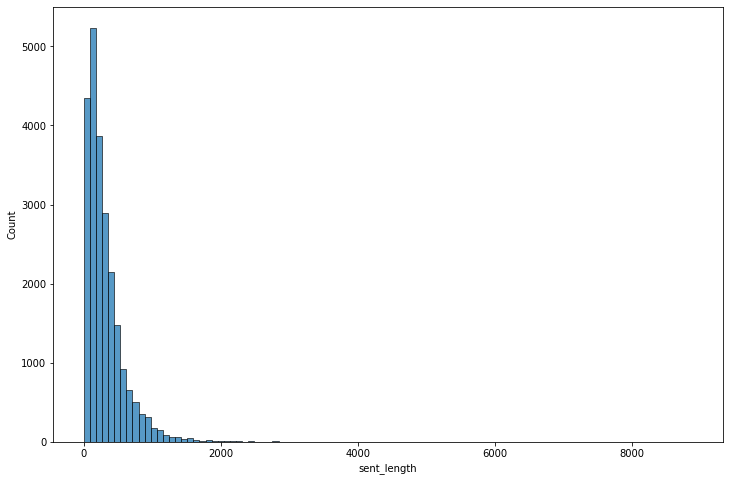

In [24]:

fig, ax = plt.subplots(1,1, figsize=(12,8))
# Histogram for the sentence length
sns.histplot(data=df, x=combined_df['sent_length'], bins = 100, ax=ax)


In [25]:
# find the rows whose sentence length is less than 27 words
combined_df_27char = combined_df[combined_df['sent_length'] < 27]
combined_df_27char.to_csv("combined_df_27char.csv")

# Find the number of sentences with labels "0", "1", and "2" in the dataframe with less than 27 charcters
df0 = combined_df_27char[combined_df_27char['jim_crow'] == 0]
df1 = combined_df_27char[combined_df_27char['jim_crow'] == 1]
df2 = combined_df_27char[combined_df_27char['jim_crow'] == 2]
print(df0)
print(df1)
print(df2)

       year           state                    sentence  jim_crow  sent_length
58     1907  SOUTH CAROLINA    provided, further, that.         0           24
73     1886  SOUTH CAROLINA      officers of the board.         0           22
74     1886  SOUTH CAROLINA                   meetings.         0            9
76     1886  SOUTH CAROLINA           local school tax.         0           17
79     1886  SOUTH CAROLINA  and protected by his bond.         0           26
...     ...             ...                         ...       ...          ...
18113  1939  NORTH CAROLINA         purpose of the act.         0           20
18115  1939  NORTH CAROLINA              appropriation.         0           14
18154  1899  NORTH CAROLINA                           :         0            1
18215  1907  NORTH CAROLINA                           q         0            1
18219  1905  NORTH CAROLINA       manner of assessment.         0           21

[681 rows x 5 columns]
       year           state 

- The number of sentences less than 25 characters are 463 and they are all labeled as 0 except one (labeled 2). So, we can delete all senetences whose length are less than 25.
- The number of sentences less than 27 characters are 684 and they are all labeled as 0 except three (one labeled 1, two lableled 2). Since we do not want to delete any sentence coded as 1, we will delete all sentences less than 22 characters.

#### Remove all the sentences with < 22 characters. Create dataset with >= 22 characaters

In [26]:
# Remove all the sentences whose length is <= characters
df_updated = combined_df[combined_df['sent_length'] >= 22]
print(" Number of rows in the reduced dataset:", len(df_updated))

 Number of rows in the reduced dataset: 23041


In [27]:
# find the data type of reduced dataframe columns
df_updated.dtypes

year            int64
state          object
sentence       object
jim_crow        int64
sent_length     int64
dtype: object

In [28]:
# Find the number of sentences with labels "0", "1", and "2"
df_0 = df_updated[df_updated['jim_crow'] == 0]
df_1 = df_updated[df_updated['jim_crow'] == 1]
df_2 = df_updated[df_updated['jim_crow'] == 2]

print("Number of sentences that are NOT jim crow =", len(df_0))
print("Number of jim crow sentences =", len(df_1))
print("Number of undecided sentences =", len(df_2))

Number of sentences that are NOT jim crow = 18056
Number of jim crow sentences = 4318
Number of undecided sentences = 667


In [29]:
df_updated.dtypes

year            int64
state          object
sentence       object
jim_crow        int64
sent_length     int64
dtype: object

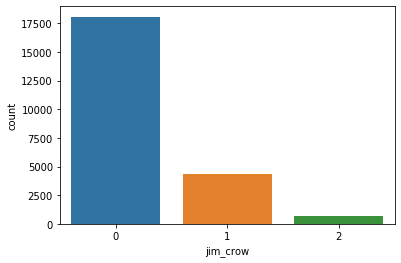

In [30]:
from seaborn import countplot

# Plot the distribution of the target (=1 that is jim_crow)
countplot(x=df_updated['jim_crow'])

In [31]:
# Check for missing values
df_updated.isnull().sum().sum()

0

In [32]:
df_0 = df_updated[df_updated['jim_crow'] == 9]
df_0

,year,state,sentence,jim_crow,sent_length


#### Check for duplicate rows 

In [46]:
#find duplicate rows...returns True or False
duplicate_rows = df_updated.duplicated()

#count of duplicate rows -- True implies the row is duplicated
truth_count = duplicate_rows.value_counts()
print(truth_count[True])

5127


In [48]:
# save the duplicated rows in csv file
duplicated_data = df_updated[df_updated.duplicated(keep=False)]
duplicated_data.to_csv('duplicate_data.csv')

In [52]:
# drop duplicate data(rows)
df_no_duplicate = df_updated.drop_duplicates() 

In [57]:
# count the length of the clean data, number of 0's and 1's there
print(len(df_no_duplicate))
print('Count of sentences labelled 0',len(df_no_duplicate[df_no_duplicate['jim_crow'] == 0]))
print('Count of sentences labelled 1', len(df_no_duplicate[df_no_duplicate['jim_crow'] == 1]))
print('Count of sentences labelled 2', len(df_no_duplicate[df_no_duplicate['jim_crow'] == 2]))

17914
Count of sentences labelled 0 14345
Count of sentences labelled 1 2908
Count of sentences labelled 2 661


#### Removing stopwords from the sentences

In [58]:
stopWords = stopwords.words("english")

# Define a function to remove stop words from a sentence 
def remove_stop_words(sentence): 
  # Split the sentence into individual words 
    words = sentence.split() 
  
  # Use a list comprehension to remove stop words 
    filtered_words = [word for word in words if word not in stopWords] 
  
  # Join the filtered words back into a sentence 
    return ' '.join(filtered_words)

In [59]:
# Remove stopwords from the 'sentence' column of the dataframe
p=[]
for i in df_no_duplicate['sentence']:
    p.append(remove_stop_words(i))
df_no_duplicate['sentence']=p
df_no_duplicate['sentence']

0        shall duty county treasurer report monthly, fi...
1        moneys disbursed county treasurer account scho...
2        county treasurer shall make forward state supe...
3        county treasurer shall carry forward sums hand...
4        shall unlawful county treasurer, county audito...
                               ...                        
23474    behalf general welfare city winston, good orde...
23475    clerk commissioners, first monday november lis...
23476    township school trustees shall divide respecti...
23477    shall consult convenience necessities race set...
23478    treasurer wilkes county hereby authorized pay ...
Name: sentence, Length: 17914, dtype: object

### Split the data into 'features' and 'target' for machine learning 

In [61]:
# Split data
features = df_no_duplicate[['year', 'sentence']]
target = df_no_duplicate['jim_crow']

In [62]:
print(features.shape, target.shape)

(17914, 2) (17914,)


In [63]:
features

,year,sentence
0,1896,"shall duty county treasurer report monthly, fi..."
1,1896,moneys disbursed county treasurer account scho...
2,1896,county treasurer shall make forward state supe...
3,1896,county treasurer shall carry forward sums hand...
4,1896,"shall unlawful county treasurer, county audito..."
...,...,...
23474,1909,"behalf general welfare city winston, good orde..."
23475,1895,"clerk commissioners, first monday november lis..."
23476,1899,township school trustees shall divide respecti...
23477,1899,shall consult convenience necessities race set...


### Machine Learning: XGBoost 

- Splitting test and training set in 20|80 ratio
- Using default values of the parameter
- Training and test set contains mixed of NC and SC sentences
- Resample training data using imblearn SMOTEN as the dataset is very imbalanced - using SMOTEN because our dataset is purely categorical (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html#imblearn.over_sampling.SMOTEN)

In [64]:
# Randomly split X and y into training (80%) and test(20%) sets

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

In [65]:
print("......TRAINING SET....")
print(" Size of X_train is: ", X_train.shape)
print(" Size of y_train is: ", y_train.shape)
print("......TEST SET....")
print(" Size of X_test is: ", X_test.shape)
print(" Size of y_test is: ", y_test.shape)


......TRAINING SET....
 Size of X_train is:  (14331, 2)
 Size of y_train is:  (14331,)
......TEST SET....
 Size of X_test is:  (3583, 2)
 Size of y_test is:  (3583,)


#### Count of 0,1,2 in training set BEFORE resampling using SMOTEN

In [66]:
# Counting 0,1,2 in y_train 
np.array(np.unique(y_train, return_counts=True)).T

array([[    0, 11464],
       [    1,  2330],
       [    2,   537]])

In [67]:
X_train.dtypes

year         int64
sentence    object
dtype: object

#### Resample the data using SMOTEN

In [68]:
sm = SMOTEN(random_state=13)
X_train, y_train = sm.fit_resample(X_train, np.array(y_train))
len(X_train)

34392

#### Count of 0,1,2 in training set AFTER resampling using SMOTEN

In [69]:
# count of 0,1,2 after using SMOTEN
np.array(np.unique(y_train, return_counts=True)).T

array([[    0, 11464],
       [    1, 11464],
       [    2, 11464]])

### Create pipeline for the analysis

In [70]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def transform(self, X, **transform_params):
        out = X[self.columns].copy()
        return out
    def fit(self, X, y=None, **fit_params):
        return self

##### Bayesian Hyperparameter search with HyperOpt

In [71]:
pipeline = Pipeline([

        ('features', FeatureUnion([

            # Extract features
            ('text_pipeline', Pipeline([
                ('get_text', SelectColumnsTransformer("sentence")),
                ('vect', CountVectorizer(decode_error = "ignore",
                      min_df = 2, max_df = 0.8)),
                ('tfidf', 'passthrough'),
            ])),
#             ('text_len', Pipeline([
#                 ('get_text', SelectColumnsTransformer("sentence")),
#                 ('length', LengthExtractor())
#             ])),
            ('metadata', SelectColumnsTransformer(['year']))
        ])),
        ('dlf',XGBClassifier(tree_method="hist"))
])

In [72]:
def objective(params):
    params['features__text_pipeline__vect__min_df'] = int(params['features__text_pipeline__vect__min_df'])
    params['dlf__max_depth'] = int(params['dlf__max_depth'])
    params['dlf__min_child_weight'] = int(params['dlf__min_child_weight'])
    params['dlf__scale_pos_weight'] = int(params['dlf__scale_pos_weight'])
    pipeline.set_params(**params)
    
    score = 1-cross_val_score(pipeline, X_train, y_train, scoring=make_scorer(f1_score, average="weighted"),
                              n_jobs=-1).mean()
    #print("F1 {:.4f} params {}".format((1-score), params))
    return score

space = {
    'features__text_pipeline__vect__min_df': hp.quniform ('features__text_pipeline__vect__min_df',2,20,1),
    'features__text_pipeline__vect__lowercase': hp.choice('features__text_pipeline__vect__lowercase',[True,False]),
    'features__text_pipeline__vect__ngram_range': hp.choice('features__text_pipeline__vect__ngram_range',[(1,1),(1,2),(1,3),(1,4)]),
    'features__text_pipeline__vect__max_df': hp.uniform('features__text_pipeline__vect__max_df',0.6,0.8),
#     'features__text_len':hp.choice('features__text_len',[Pipeline([
#             ('get_text', SelectColumnsTransformer("sentence")),
#             ('length', LengthExtractor())
#         ])]),
    'dlf__max_depth': hp.quniform('dlf__max_depth', 2, 10, 1),
    'dlf__min_child_weight': hp.quniform('dlf__min_child_weight', 1, 5, 1),
    'dlf__colsample_bytree': hp.uniform('dlf__colsample_bytree', 0.3, 1.0),
    'dlf__learning_rate': hp.uniform('dlf__learning_rate', 0.05, 1),
    'dlf__scale_pos_weight': hp.quniform('dlf__scale_pos_weight',1,8,1),
    'dlf__gamma': hp.uniform('dlf__gamma',0,2)
    
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100, #actual fit was run with 1000 evals
           trials=trials)

100%|██████████| 100/100 [18:58<00:00, 11.38s/trial, best loss: 0.039574482791014276]


In [73]:
model_params = space_eval(space, best)
model_params['features__text_pipeline__vect__min_df'] = int(model_params['features__text_pipeline__vect__min_df'])
model_params['dlf__max_depth'] = int(model_params['dlf__max_depth'])
model_params['dlf__min_child_weight'] = int(model_params['dlf__min_child_weight'])
# model_params['dlf__scale_pos_weight'] = int(model_params['dlf__scale_pos_weight'])

In [74]:
model_params

{'dlf__colsample_bytree': 0.4582322269971355,
 'dlf__gamma': 1.207848863216088,
 'dlf__learning_rate': 0.12394149171874647,
 'dlf__max_depth': 8,
 'dlf__min_child_weight': 1,
 'dlf__scale_pos_weight': 7.0,
 'features__text_pipeline__vect__lowercase': True,
 'features__text_pipeline__vect__max_df': 0.6010106391459717,
 'features__text_pipeline__vect__min_df': 2,
 'features__text_pipeline__vect__ngram_range': (1, 1)}

In [75]:
best_model = pipeline
best_model.set_params(**model_params)
best_model.fit(X_train,y_train)


[20:24:57] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('get_text',
                                                                  SelectColumnsTransformer(columns='sentence')),
                                                                 ('vect',
                                                                  CountVectorizer(decode_error='ignore',
                                                                                  max_df=0.6010106391459717,
                                                                                  min_df=2)),
                                                                 ('tfidf',
                                                                  'passthrough')])),
                                                ('metadata',
                                                 SelectColumnsTransformer(columns=['year']))])),
              

#### Design confusion matrix

[Text(0.5, 1, 'Overall')]

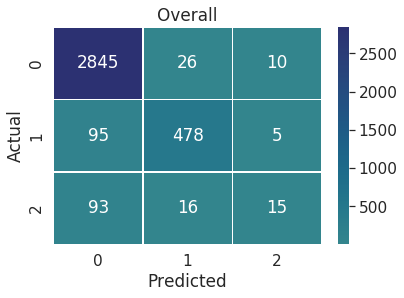

In [76]:
#predict the labels of test data 
y_pred = best_model.predict(X_test)

# count the number of labels
labels = np.unique(y_pred)

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f', center=0.8, cmap='crest', linewidth=.5)
ax.set(title="Overall")

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2881
           1       0.92      0.83      0.87       578
           2       0.50      0.12      0.19       124

    accuracy                           0.93      3583
   macro avg       0.79      0.65      0.68      3583
weighted avg       0.92      0.93      0.92      3583

